# Binary classification (Trauma detection)

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

GLB_INSTALL_DEPENDENCIES = False

In [2]:
# Here to define dependencies
# if GLB_INSTALL_DEPENDENCIES:

In [3]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import json

import src.multi_label_classif_model_utilities as mlclassif_utilities

## Globals

In [15]:
PATH_DATASET = "input/dataset/Dataset.xlsx"
PATH_DIR_LOGS = "logs/"
PATH_DIR_MODELS = "models/"
INDEX_COLUMNS_DATASET = 0
LIST_NAME_COLUMNS_DATASET = ["id_document", "id_annotation", "span", "role", "trauma", "court"]

GLB_RETURN_ATTENTION_MASK = True
GLB_CROSS_VALIDATION = False
GLB_SAVE_MODEL = False
GLB_STORE_STATISTICS_MODEL = False
GLB_TEST_MODEL = False

# Globals for the model
EPOCHS = 3
EMBEDDING_SIZE = 512
NUM_CLASSES = 2
BATCH_SIZE = 8

## Dataset

In [7]:
df_dataset = mlclassif_utilities.import_dataset_from_excel(PATH_DATASET, INDEX_COLUMNS_DATASET, LIST_NAME_COLUMNS_DATASET)
df_dataset.head()

,id_document,id_annotation,span,role,trauma,court
0,639a477897ad59b4cfc5684f,639a486397ad59b4cfc56857,PROCEEDINGS (Court opens at 0901H),Court Proceedings,0,ECCC
1,639a477897ad59b4cfc5684f,639a489f97ad59b4cfc56858,MR. PRESIDENT: Please be seated. The Court is ...,JudgeProc,0,ECCC
2,639a477897ad59b4cfc5684f,639a48a397ad59b4cfc56859,"THE GREFFIER: Mr. President, for today's proce...",Court Proceedings,0,ECCC
3,639a477897ad59b4cfc5684f,639a48f197ad59b4cfc5685e,MR. PRESIDENT: And Defence Counsel for Khieu S...,JudgeProc,0,ECCC
4,639a477897ad59b4cfc5684f,639a491c97ad59b4cfc56861,MR. PRESIDENT: The Chamber now hands the floor...,JudgeProc,0,ECCC


In [8]:
classes_dataset = mlclassif_utilities.get_unique_values_from_dataset(df_dataset, "trauma")
print(f"Num of different traumas in the dataset is {len(classes_dataset)} which are:")
for index, elem in enumerate(classes_dataset):
    print("\t", index+1, "-", elem)

Num of different traumas in the dataset is 1 which are:
	 1 - 0


### Distribution of all classes within the dataset

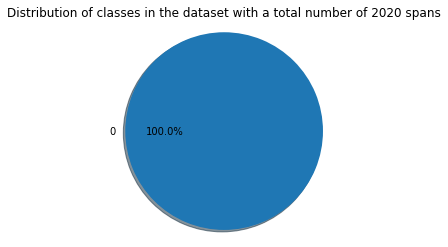

,trauma,span
0,0,2020


In [10]:
distribution_classes = mlclassif_utilities.get_distribution_classes_from_dataset(df_dataset, ["trauma"], "span")

labels = list(distribution_classes["trauma"])
sizes = list(distribution_classes["span"])

fig1, ax1 = plt.subplots()
ax1.set_title(f'Distribution of classes in the dataset with a total number of {distribution_classes["span"].sum()} spans')
ax1.pie(sizes, labels=labels, autopct='%2.1f%%', shadow=True, startangle=0) #'%1.1f%%'
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

distribution_classes

## Setup

### Device

Get the GPU device if exists, otherwise get the cpu as default dev.

In [11]:
device = mlclassif_utilities.get_gpu_device_if_exists()

print(f"\n\n==> Selected device is '{device}' <==")

There are 1 GPU(s) available.

These are the available devices:
	 1 - NVIDIA GeForce GTX 1660 Ti


==> Selected device is 'cuda' <==


## Model

### Tokenizer

In [12]:
#If no parameters are sent, default values are considered. 
#    IDModel:      Bert
#    Model namel:  bert-base-uncased
#    Do uncase:    True

tokenizer = mlclassif_utilities.get_tokenizer() 

Loading BERT tokenizer...
Bert tokenizer was loaded successfully (bert-base-uncased) 
	 do_lower_case=True


In [13]:
list_all_spans = list(df_dataset["span"])
list_all_classes = list(df_dataset["trauma"])

### Max length of a sentence among all sentences within the dataset

In [14]:
mlclassif_utilities.get_max_length_of_a_sentence_among_all_sentences(tokenizer, list_all_spans, False)

Max sentence length:  297 found at index 467 . Sentence is:


 This witness could come into the Court today and the Prosecution could put its 11 or 15 statements that this witness has made into the witness's hands; we could start at page 1 and work our way through it.  What would be the difference in doing that?  That is not the practice in this Tribunal.  This witness has come to give oral testimony.  If there is, in fact, a document that this witness can have access to, to refresh his memory, then, first of all, it depends on the nature of the document.  One has to stress caution if it's his own statement and one should, in one's submission, only permit that exercise to take place when, in fact, the statement that is made is sufficiently contemporaneous with the facts that it relates to as to minimise inaccuracies and ensure, as it were, a relative degree of validity because of its contemporaneous nature. In fact, that is an exception to the rule whereby statements cannot be put in t

297

### Tokenize sentences

In [16]:
# If _return_attention_mask, a tuple of two lists is given (tensor_of_inputs, tensor_of_attention_masks)
all_spans_tokenized = mlclassif_utilities.get_all_spans_tokenized(
    mlclassif_utilities.GLB_BERT_MODEL_ID, 
    tokenizer,
    list_all_spans,
    _add_special_tokens = True, 
    _max_length = 512,
    _pad_to_max_length = True,
    _return_attention_mask = GLB_RETURN_ATTENTION_MASK, 
    type_tensors = mlclassif_utilities.GLB_PYTORCH_TENSOR_TYPE
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/iolguin/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [17]:
input_ids = None
attention_masks = None

if GLB_RETURN_ATTENTION_MASK:
    input_ids = mlclassif_utilities.convert_list_into_pytorch_tensor(all_spans_tokenized[0])
    attention_masks = mlclassif_utilities.convert_list_into_pytorch_tensor(all_spans_tokenized[1])
else:
    input_ids = mlclassif_utilities.convert_list_into_pytorch_tensor(all_spans_tokenized)

### Split dataset

In [18]:
numeric_classes = mlclassif_utilities.convert_list_span_classes_into_numeric_values(classes_dataset, list_all_classes)
numeric_classes = mlclassif_utilities.convert_list_labels_into_pytorch_tensor(numeric_classes)

In [19]:
### Split dataset
if not GLB_CROSS_VALIDATION:
    train_labels_corpus, train_input_ids, train_attention_masks, val_labels_corpus, val_input_ids, val_attention_masks, test_labels_corpus, test_input_ids, test_attention_masks = mlclassif_utilities.split_dataset_train_val_test(numeric_classes, input_ids, attention_masks)
else:
    ### Pending k-Fold
    train_val_corpus_cross_validation, test_corpus_cross_validation = mlclassif_utilities.split_dataset_train_val_test_k_fold(numeric_classes, input_ids, attention_masks, 0.1)

    #test_labels_corpus, test_input_ids, test_attention_masks = 
    #train_labels_corpus, train_input_ids, train_attention_masks, val_labels_corpus, val_input_ids, val_attention_masks,

CORPUS TRAINING AND VALIDATION:  
	 Length labels 1919 
	 Length input_ids 1919 
	 Length attention_masks 1919 

	CORPUS TRAINING:  
		 Length labels 1727 
		 Length input_ids 1727 
		 Length attention_masks 1727
	CORPUS VALIDATION:  
		 Length labels 192 
		 Length input_ids 192 
		 Length attention_masks 192

CORPUS TEST:  
	 Length labels 101 
	 Length input_ids 101 
	 Length attention_masks 101 



### Create datasets and dataloaders

In [21]:
train_dataset = mlclassif_utilities.create_tensor_dataset(train_input_ids, train_attention_masks, train_labels_corpus)
val_dataset = mlclassif_utilities.create_tensor_dataset(val_input_ids, val_attention_masks, val_labels_corpus)
test_dataset = mlclassif_utilities.create_tensor_dataset(test_input_ids, test_attention_masks, test_labels_corpus)

train_dataloader = mlclassif_utilities.create_dataloader(train_dataset, BATCH_SIZE)
val_dataloader = mlclassif_utilities.create_dataloader(val_dataset, BATCH_SIZE)
test_dataloader = mlclassif_utilities.create_dataloader(test_dataset, BATCH_SIZE)

### Create model

In [22]:
model = mlclassif_utilities.create_model(
    mlclassif_utilities.GLB_BERT_MODEL_ID,
    mlclassif_utilities.GLB_BERT_BASE_UNCASED_MODEL_NAME,
    NUM_CLASSES,
    True #RunInGPU
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Get optimizer and scheduler